import package

In [1]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

讀取資料

In [2]:
dataset = pd.read_csv('temp_data_2022-08-04_2022-08-06.csv', engine='python')
dataset = dataset.fillna(dataset.bfill())
date_time = pd.to_datetime(dataset.pop('time'), format='%Y.%m.%d')
print(dataset.head())

column_indices = {name: i for i, name in enumerate(dataset.columns)}

   value
0   24.9
1   24.7
2   24.8
3   24.4
4   24.6


拆分數據

In [3]:
n = len(dataset)
train_df = dataset[0:int(n * 0.7)]
val_df = dataset[int(n * 0.7):int(n * 0.9)]
test_df = dataset[int(n * 0.9):]

數據正規化

In [4]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

num_features = dataset.shape[1]

Data windowing-設計資料輸入方式

In [5]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Split

In [6]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window

數據可視化

In [7]:
def plot(self, model=None, plot_col='value', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')
    plt.show()


WindowGenerator.plot = plot

創建資料集

In [8]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    '''
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32, )
    '''
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32, )
    ds = ds.map(self.split_window)
    return ds


WindowGenerator.make_dataset = make_dataset

定義屬性

In [9]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

添加屬性及建立物件

In [10]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['value'])

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['value'])

設定訓練參數

In [11]:
MAX_EPOCHS = 80


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                         patience=patience,
                         mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

建立線性模型

In [12]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

訓練線性模型並預測與可視化

Epoch 1/80
7/7 [==============================] - 0s 11ms/step - loss: 0.3659 - mean_absolute_error: 0.4886 - val_loss: 0.8701 - val_mean_absolute_error: 0.9048


2022-08-06 14:44:35.956634: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 2/80
7/7 [==============================] - 0s 5ms/step - loss: 0.3580 - mean_absolute_error: 0.4829 - val_loss: 0.8538 - val_mean_absolute_error: 0.8963
Epoch 3/80
7/7 [==============================] - 0s 4ms/step - loss: 0.3502 - mean_absolute_error: 0.4769 - val_loss: 0.8369 - val_mean_absolute_error: 0.8873
Epoch 4/80
7/7 [==============================] - 0s 4ms/step - loss: 0.3430 - mean_absolute_error: 0.4713 - val_loss: 0.8200 - val_mean_absolute_error: 0.8783
Epoch 5/80
7/7 [==============================] - 0s 5ms/step - loss: 0.3354 - mean_absolute_error: 0.4654 - val_loss: 0.8041 - val_mean_absolute_error: 0.8697
Epoch 6/80
7/7 [==============================] - 0s 4ms/step - loss: 0.3278 - mean_absolute_error: 0.4594 - val_loss: 0.7895 - val_mean_absolute_error: 0.8618
Epoch 7/80
7/7 [==============================] - 0s 4ms/step - loss: 0.3208 - mean_absolute_error: 0.4536 - val_loss: 0.7729 - val_mean_absolute_error: 0.8527
Epoch 8/80
7/7 [========================

Epoch 53/80
7/7 [==============================] - 0s 4ms/step - loss: 0.1068 - mean_absolute_error: 0.2502 - val_loss: 0.2293 - val_mean_absolute_error: 0.4589
Epoch 54/80
7/7 [==============================] - 0s 4ms/step - loss: 0.1043 - mean_absolute_error: 0.2470 - val_loss: 0.2225 - val_mean_absolute_error: 0.4517
Epoch 55/80
7/7 [==============================] - 0s 4ms/step - loss: 0.1017 - mean_absolute_error: 0.2439 - val_loss: 0.2156 - val_mean_absolute_error: 0.4444
Epoch 56/80
7/7 [==============================] - 0s 4ms/step - loss: 0.0993 - mean_absolute_error: 0.2409 - val_loss: 0.2091 - val_mean_absolute_error: 0.4374
Epoch 57/80
7/7 [==============================] - 0s 4ms/step - loss: 0.0968 - mean_absolute_error: 0.2378 - val_loss: 0.2022 - val_mean_absolute_error: 0.4297
Epoch 58/80
7/7 [==============================] - 0s 4ms/step - loss: 0.0943 - mean_absolute_error: 0.2347 - val_loss: 0.1946 - val_mean_absolute_error: 0.4212
Epoch 59/80
7/7 [=================

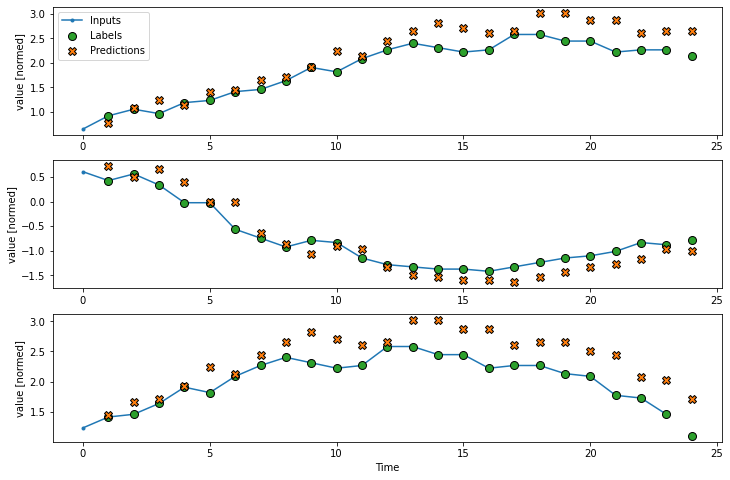

In [13]:
history = compile_and_fit(linear, single_step_window)

val_performance = {}
performance = {}

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

wide_window.plot(linear)

建立conv_window

In [14]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['value'])

建立CNN模型

In [15]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

訓練CNN模型

2/2 [==============================] - 0s 880us/step - loss: 0.0117 - mean_absolute_error: 0.0901


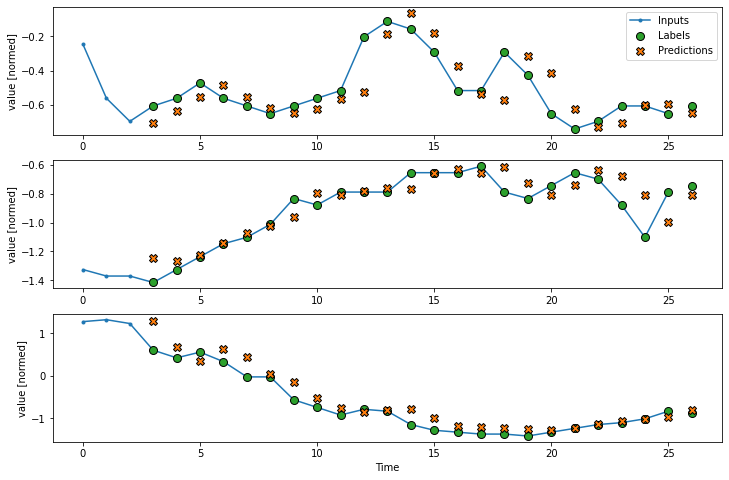

In [16]:
history = compile_and_fit(conv_model, conv_window, 10)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['value'])

wide_conv_window.plot(conv_model)

建立LSTM模型

In [17]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

訓練LSTM模型

2/2 [==============================] - 0s 1ms/step - loss: 0.0301 - mean_absolute_error: 0.1190


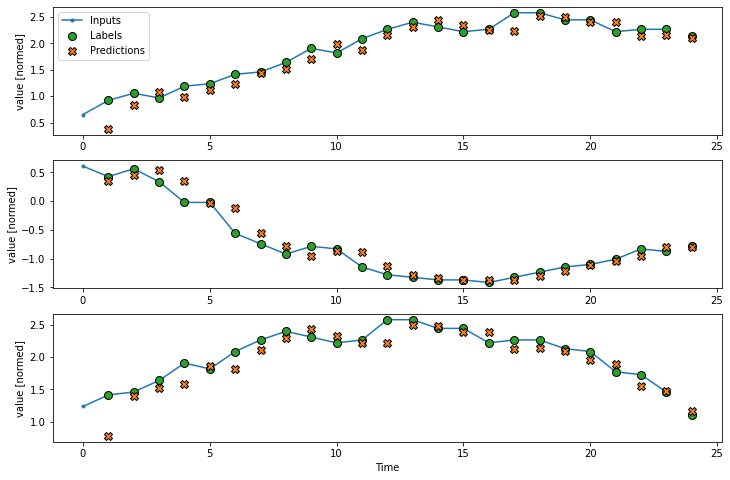

In [18]:
history = compile_and_fit(lstm_model, wide_window, 10)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model)

建立比較圖

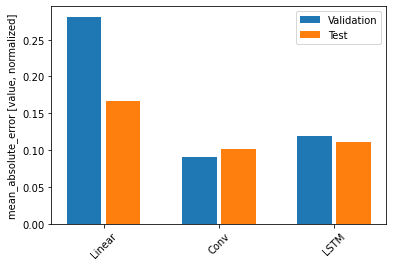

In [19]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [value, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
plt.show()

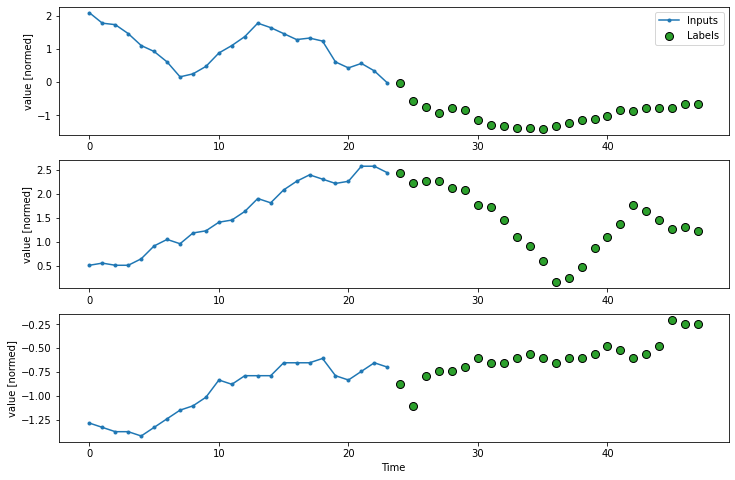

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [20]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                label_width=OUT_STEPS,
                shift=OUT_STEPS)

multi_window.plot()
multi_window

1/1 [==============================] - 0s 20ms/step - loss: 0.1064 - mean_absolute_error: 0.2713


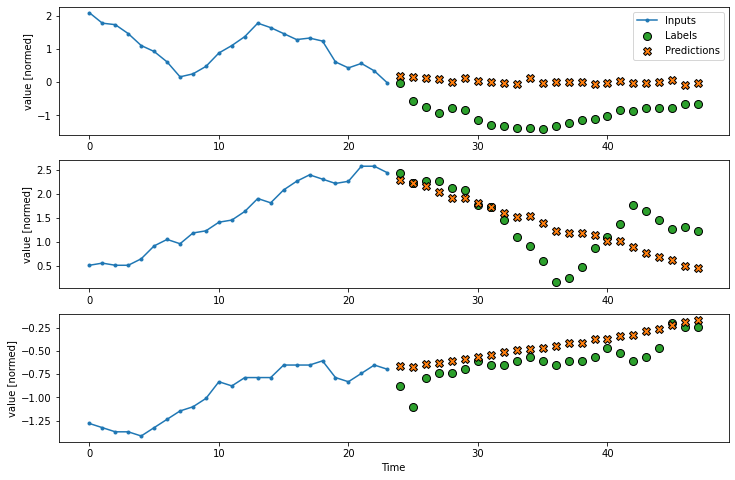

In [21]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window, 10)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

1/1 [==============================] - 0s 21ms/step - loss: 1.1568 - mean_absolute_error: 0.9746


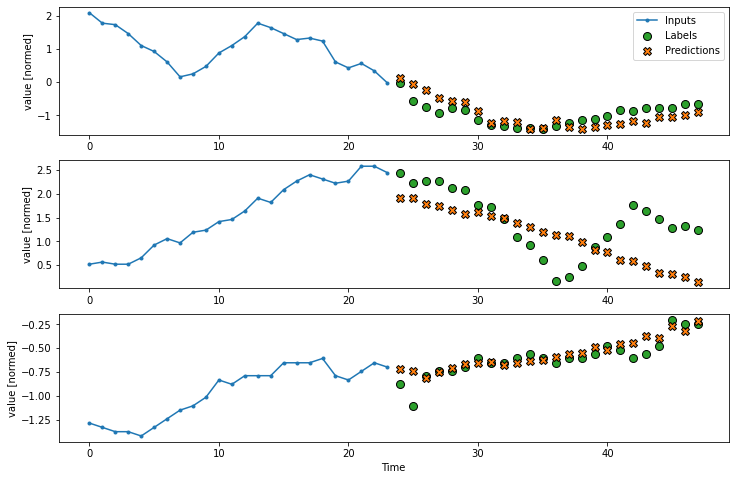

In [22]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False)),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, 10)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [23]:
multi_performance


{'Conv': [], 'LSTM': []}

In [24]:
x = np.arange(len(multi_performance))
width = 0.3
print(x)

[0 1]


In [25]:
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
print(metric_index)

1


In [26]:
val_mae = [v[metric_index] for v in multi_val_performance.values()]

In [27]:
multi_performance.values()

dict_values([[], []])

In [28]:
test_mae = [v[metric_index] for v in multi_performance.values()]

IndexError: list index out of range

In [23]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

IndexError: list index out of range